In [ ]:
# This work relies on the the fantatic fastai library v1 (https://github.com/fastai/fastai1) 
# and image_tabular library (https://github.com/naity/image_tabular)
# Before runing this notebook, please run 'coda env create -f environment_jointDeepLearning.yml' in the terminal or Anaconda Prompt
# Then, Activate the new environment

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.tabular import *

In [3]:
# from image_tabular.core import *
# from image_tabular.dataset import *
# from image_tabular.model import *
# from image_tabular.metric import *
from importlib import reload

import image_tabular.core;reload(image_tabular.core)
from image_tabular.core import *

import image_tabular.dataset;reload(image_tabular.dataset)
from image_tabular.dataset import *


import image_tabular.model;reload(image_tabular.model)
from image_tabular.model import *


import image_tabular.metric;reload(image_tabular.metric)
from image_tabular.metric import *

In [4]:
torch.cuda.is_available()

True

In [5]:
# use gpu by default if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [7]:
data_path = Path("./data/artifact-instruction-classification/")

In [9]:
# We use 79 samples for demonstration
train_df = pd.read_csv(data_path/"train.csv")
test_df = pd.read_csv(data_path/"test.csv")

print(len(train_df), len(test_df))

71 8


In [10]:
# For demonstration purposes, there are only two artifact categories in this demo:
# 'presentation' and 'other'
train_df['target'] = train_df['instruction_cat'].map({'presentation':1,'other':0})

In [11]:
# Check if the dataset is extremely unbalanced
train_df["target"].value_counts(normalize=True)

0    0.507042
1    0.492958
Name: target, dtype: float64

## Image data

In [12]:
tfms = get_transforms(do_flip=False, max_rotate=1.)
size = 128

In [13]:
# idx for validation, shared by image and tabular data
val_idx = get_valid_index(train_df)
len(val_idx)

14

In [14]:
# load image data using train_df and prepare fastai LabelLists
image_data = (ImageList.from_df(train_df, path=data_path, cols="artifact_id",
                               folder="train", suffix=".jpg")
              .split_by_idx(val_idx)
              .label_from_df(cols="target")
              .transform(tfms, size=size))

# add test data so that we can make predictions
test_image_data = ImageList.from_df(test_df, path=data_path, cols="artifact_id",
                                    folder="test", suffix=".jpg")
image_data.add_test(test_image_data)

LabelLists;

Train: LabelList (57 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,1,0,0
Path: data/artifact-instruction-classification;

Valid: LabelList (14 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,1,1,0,1
Path: data/artifact-instruction-classification;

Test: LabelList (8 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data/artifact-instruction-classification

1


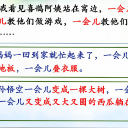

In [15]:
# show one example image
print(image_data.train[0][1])
image_data.train[0][0]

## Tabular data

In [17]:
train_df.columns[:25]

Index(['artifact_id', 'instruction_cat', 'proportion_text',
       'proportion_interaction', 'proportion_picture', 'proportion_graph',
       'number_interaction', 'number_picture_graph', 'has_table', 'only_text',
       'has_interaction', 'has_picture', 'has_cartoon', 'segmenting',
       'signaling', 'coherence', 'in-class_submissions',
       'after-class_submisson', 'sharing_outcomes', 'student_discussions',
       'learning_groups', 'wv_0', 'wv_1', 'wv_2', 'wv_3'],
      dtype='object')

In [18]:
dep_var = 'target'
cat_names = ['has_table', 'only_text','has_interaction', 'has_picture', 'has_cartoon', 'segmenting',
       'signaling', 'coherence']
cont_names = ['proportion_text',
       'proportion_interaction', 'proportion_picture', 'proportion_graph',
       'number_interaction', 'number_picture_graph', 'has_table','in-class_submissions', 'after-class_submisson', 'sharing_outcomes', 'student_discussions', 'learning_groups']+['wv_{}'.format(i) for i in np.arange(300)]
procs = [FillMissing, Categorify, Normalize]

In [19]:
tab_data = (TabularList.from_df(train_df, path=data_path, 
#                                 cat_names=cat_names, 
                                cont_names=cont_names, procs=procs)
                           .split_by_idx(val_idx)
                           .label_from_df(cols=dep_var))

In [20]:
# add test
tab_data.add_test(TabularList.from_df(test_df, 
#                                       cat_names=cat_names,
                                      cont_names=cont_names,
                                      processor = tab_data.train.x.processor))

LabelLists;

Train: LabelList (57 items)
x: TabularList
proportion_text 0.9514; proportion_interaction -0.5415; proportion_picture -0.6409; proportion_graph -0.4010; number_interaction -0.5827; number_picture_graph -0.6988; has_table -0.2336; in-class_submissions -0.8596; after-class_submisson -0.1743; sharing_outcomes -1.0382; student_discussions -0.4181; learning_groups -0.3377; wv_0 -0.5687; wv_1 -1.0255; wv_2 -0.2540; wv_3 -0.9540; wv_4 0.8661; wv_5 0.7606; wv_6 0.6766; wv_7 -0.3105; wv_8 -0.9953; wv_9 -0.4923; wv_10 0.6669; wv_11 -1.0699; wv_12 0.1772; wv_13 -0.9750; wv_14 -0.8757; wv_15 0.1524; wv_16 -0.3259; wv_17 0.8327; wv_18 -0.1123; wv_19 0.8095; wv_20 0.2688; wv_21 -0.2312; wv_22 -1.0211; wv_23 0.4580; wv_24 1.0783; wv_25 -0.4268; wv_26 -0.8373; wv_27 0.8883; wv_28 -0.8543; wv_29 1.2679; wv_30 -0.9365; wv_31 -1.0013; wv_32 -0.7084; wv_33 0.8945; wv_34 -0.7775; wv_35 0.5289; wv_36 -0.1565; wv_37 1.0057; wv_38 0.1033; wv_39 -1.0216; wv_40 -0.7364; wv_41 -0.6173; wv_42 2.1222;

## Integrate image and tabular data

In [21]:
integrate_train, integrate_valid, integrate_test = get_imagetabdatasets(image_data, tab_data)

In [22]:
# package train, valid, and test datasets into a fastai databunch
bs = 16

db = DataBunch.create(integrate_train, integrate_valid, integrate_test,
                      path=data_path, bs=bs)
db

DataBunch;

Train: <image_tabular.dataset.ImageTabDataset object at 0x7fb448c48bd0>;

Valid: <image_tabular.dataset.ImageTabDataset object at 0x7fb46007dc50>;

Test: <image_tabular.dataset.ImageTabDataset object at 0x7fb4624c8b90>

In [23]:
# image normalization with imagenet_stats
db.norm, db.denorm = normalize_funcs_image_tab(*imagenet_stats)
db.add_tfm(db.norm)

In [24]:
# check the shape of one batch
x, y = next(iter(db.train_dl))
len(x)

2

In [25]:
# images
x[0].shape

torch.Size([16, 3, 128, 128])

In [26]:
# categorical and continuous tabular data 
x[1][0].shape, x[1][1].shape

(torch.Size([16]), torch.Size([16, 312]))

In [27]:
# targets
y.shape

torch.Size([16])

## Model that trains on image and tabular data simultaneously

In [31]:
# cnn model for images, use Resnet50 as an example
cnn_arch = models.resnet50

# cnn_out_sz is the output size of the cnn model that will be concatenated with tabular model output
cnn_out_sz = 256

# use fastai functions to get a cnn model
image_data_db = image_data.databunch()
image_data_db.c = cnn_out_sz
cnn_learn = cnn_learner(image_data_db, cnn_arch, ps=0.2)
cnn_model = cnn_learn.model

/home/e2lab/anaconda3/envs/fastai1_imgtabular/lib/python3.7/site-packages/fastai/basic_data.py:248: UserWarning: Your training dataloader is empty, you have only 57 items in your training set.
                 Your batch size is 64, you should lower it.
  Your batch size is {self.train_dl.batch_size}, you should lower it.""")


You can deactivate this warning by passing `no_check=True`.


In [32]:
# get embedding sizes of categorical data
emb_szs = tab_data.train.get_emb_szs()

# output size of the tabular model that will be concatenated with cnn model output
tab_out_sz = 8

# use fastai functions to get a tabular model
tabular_model = TabularModel(emb_szs, len(cont_names), out_sz=tab_out_sz, layers=[8], ps=0.2)
tabular_model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=312, out_features=8, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=8, out_features=8, bias=True)
  )
)

In [33]:
# get an integrated model that combines the two components and concatenate their outputs
# which will pass through additional fully connected layers
integrate_model = CNNTabularModel(cnn_model,
                                  tabular_model,
                                  layers = [cnn_out_sz + tab_out_sz, 32],
                                  ps=0.2,
                                  out_sz=2).to(device)

In [34]:
# check model output dimension, should be (bs, 2)
integrate_model(*x).shape

torch.Size([16, 2])

In [35]:
# adjust loss function weight because the dataset is extremely unbalanced
weights = [1/(1-train_df["target"].mean()), 1/train_df["target"].mean()]
loss_func = CrossEntropyFlat(weight=torch.FloatTensor(weights).to(device))

In [36]:
# package everything in a fastai learner, add auc roc score as a metric
learn = Learner(db, integrate_model, metrics=[accuracy, ROCAUC()], loss_func=loss_func)

In [37]:
# organize layer groups in order to use differential learning rates provided by fastai
# the first two layer groups are earlier layers of resnet
# the last layer group consists of the fully connected layers of cnn model, tabular model,
# and final fully connected layers for the concatenated data
learn.layer_groups = [nn.Sequential(*flatten_model(cnn_learn.layer_groups[0])),
                      nn.Sequential(*flatten_model(cnn_learn.layer_groups[1])),
                      nn.Sequential(*(flatten_model(cnn_learn.layer_groups[2]) +
                                      flatten_model(integrate_model.tabular_model) +
                                      flatten_model(integrate_model.layers)))]

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


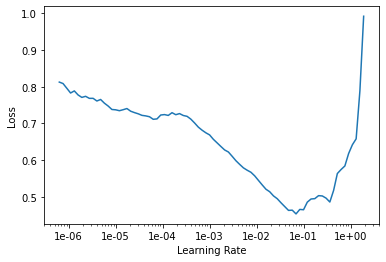

In [38]:
# find learning rate to train the last layer group first 
learn.freeze()
learn.lr_find()
learn.recorder.plot()

In [39]:
# train
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.781607,0.717926,0.428571,0.489796,00:02
1,0.800695,0.739433,0.357143,0.408163,00:02
2,0.803578,0.708570,0.428571,0.510204,00:02
3,0.777196,0.685144,0.571429,0.612245,00:02
4,0.748922,0.649313,0.571429,0.714286,00:02
5,0.724302,0.625094,0.642857,0.755102,00:02
6,0.697581,0.606869,0.714286,0.795918,00:02
7,0.691876,0.607330,0.714286,0.795918,00:02
8,0.686899,0.595957,0.714286,0.795918,00:02
9,0.680607,0.599145,0.642857,0.795918,00:02


In [40]:
# train
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.520512,0.602243,0.642857,0.775510,00:02
1,0.568140,0.581302,0.642857,0.795918,00:02
2,0.605732,0.578770,0.642857,0.836735,00:02
3,0.596814,0.556676,0.714286,0.857143,00:02
4,0.567636,0.528306,0.785714,0.918367,00:02
5,0.553734,0.511237,0.785714,0.918367,00:02
6,0.541098,0.500415,0.785714,0.918367,00:02
7,0.531057,0.510389,0.785714,0.897959,00:02
8,0.534434,0.501963,0.785714,0.897959,00:02
9,0.521985,0.500438,0.785714,0.897959,00:02


In [41]:
# unfreeze all layer groups to train the entire model using differential learning rates
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.450496,0.503126,0.785714,0.877551,00:02
1,0.443965,0.488864,0.785714,0.918367,00:02
2,0.454675,0.486868,0.785714,0.938776,00:02
3,0.465369,0.483219,0.785714,0.897959,00:02
4,0.468321,0.483457,0.785714,0.897959,00:02


In [42]:
# train the entire model using differential learning rates
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.413452,0.487953,0.714286,0.918367,00:02
1,0.430470,0.470334,0.857143,0.918367,00:02
2,0.413037,0.468226,0.857143,0.897959,00:02
3,0.386266,0.463000,0.857143,0.897959,00:02
4,0.376347,0.454158,0.857143,0.918367,00:02


In [47]:
# train the entire model using differential learning rates
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,rocauc,time
0,0.302802,0.410214,0.857143,0.918367,00:02
1,0.292332,0.403268,0.857143,0.918367,00:02
2,0.281865,0.396784,0.857143,0.918367,00:02
3,0.287546,0.399562,0.857143,0.938776,00:02
4,0.279131,0.399961,0.857143,0.959184,00:02


The model achieved an ROC AUC score of about 0.87 on the validation set.

## Prediction

In [48]:
# make predictions for the test set
preds, y = learn.get_preds(DatasetType.Test)

In [52]:
preds.numpy().argmax(1)

array([0, 1, 1, 0, 0, 0, 1, 1])

In [54]:
test_df['instruction_cat']

0           other
1    presentation
2    presentation
3           other
4           other
5           other
6    presentation
7    presentation
Name: instruction_cat, dtype: object